## Dataset:
https://www.kaggle.com/datasets/preetviradiya/covid19-radiography-dataset

## Imports

In [ ]:
!python -m pip install --upgrade pip
!pip install opencv-contrib-python pandas matplotlib os ipywidgets ipython

In [1]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import os

In [2]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def showme(frame,title=None):
    #window_title = "map"
    cv2.namedWindow(title, cv2.WINDOW_NORMAL) #open a window
    cv2.imshow(title, frame)                  #show the image in that widow
    cv2.waitKey(0)                            #wait for any key
    cv2.destroyAllWindows()                   #close everything

def showplt(image, title=None, pltnative=False, custSize=[100,10], cmap='gray'):
    plt.figure(figsize = (custSize))
    if pltnative:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image[...,::-1], cmap=cmap)
    plt.title(title)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

## SETUP

In [4]:
covid_folder = os.path.join("..","data","COVID-19_Radiography_Dataset", "COVID")
covid_annotations_folder = os.path.join("..","data","COVID-19_Radiography_Dataset", "COVID - Annotations")
normal_folder = os.path.join("..","data", "COVID-19_Radiography_Dataset","Normal")


In [5]:
os.listdir(covid_folder)

['COVID-1.png',
 'COVID-1010.png',
 'COVID-1011.png',
 'COVID-1012.png',
 'Thumbs.db']

## Reading Images

In [6]:
image_file_name = "COVID-1010.png"

In [7]:
co1010_orig = cv2.imread(os.path.join(covid_folder ,image_file_name ))
co1010_anno = cv2.imread(os.path.join(covid_annotations_folder ,image_file_name ))


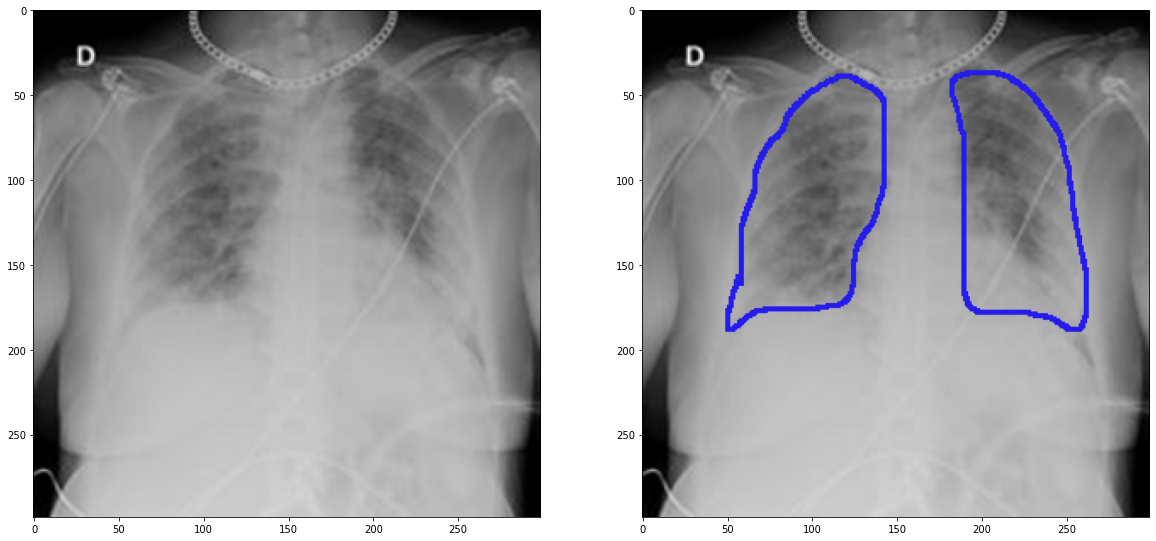

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(co1010_orig)
ax[1].imshow(co1010_anno) ## [...,::-1]
## ax[1].imshow(co1010_anno[...,::-1]) ## for actual colors

## Obtaining the Difference

In [9]:
diff = co1010_orig - co1010_anno
# diff = diff[:,:,0]
diff_mean = diff.mean(axis=2)
diff_sum = diff.sum(axis=2)



## Thresholding the Difference

In [ ]:
diff_tr = cv2.threshold(diff,0,255,0) ## Treasholded
diff_tr = diff_tr[1]                  ## take oly one layer!!

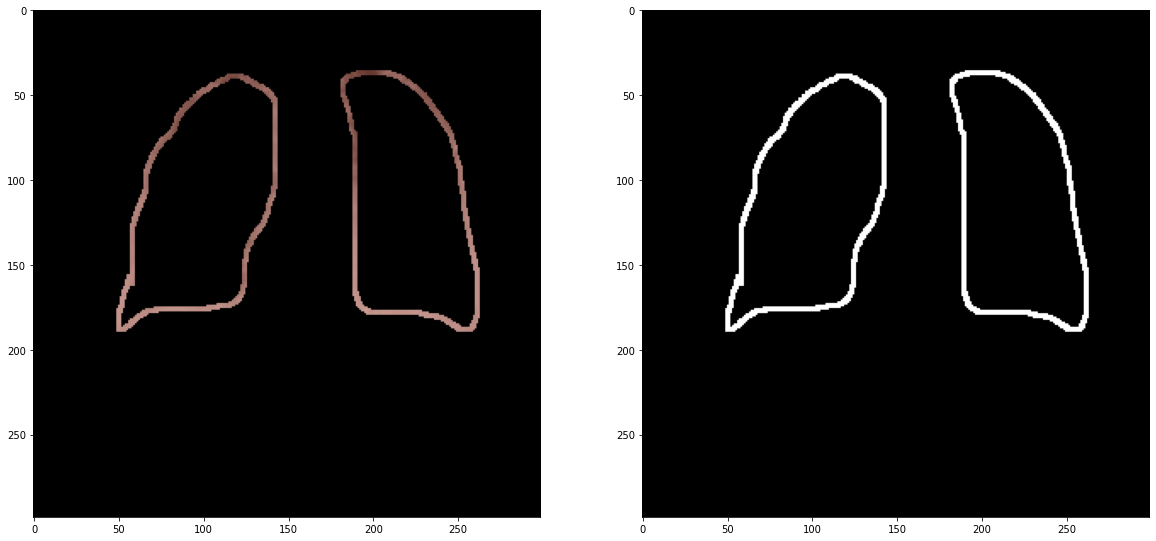

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(diff[...,::-1])               ## Not Tresholded
ax[1].imshow(diff_tr)                      ## Tresholded

## Manipulation: Eroded edges

In [11]:
kernel0 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
eroded  = cv2.erode(diff_tr.astype('uint8'), kernel0, iterations = 1)

## Manipulation: Dilated edges

In [ ]:
dilated = cv2.dilate(diff_tr, kernel0, iterations=2)
dilated5 = cv2.dilate(diff_tr, kernel0, iterations=5)

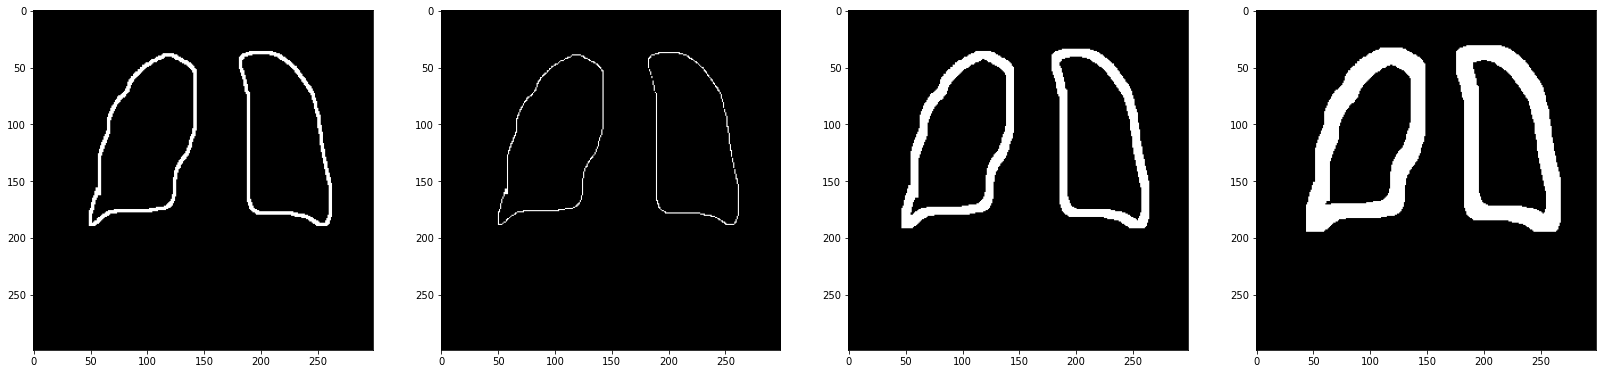

In [12]:
fig, ax = plt.subplots(1,4, figsize=(28,10))
ax[0].imshow(diff_tr)
ax[1].imshow(eroded)
ax[2].imshow(dilated)
ax[3].imshow(dilated5)

## Floodfilling

In [13]:
height, width = co1010_orig.shape[:-1]

## A new mask for each floodfill opertion:

mask_ff0 = np.zeros((height + 2, width + 2), np.uint8)
diff_tr_ff = cv2.floodFill(diff_tr.astype('uint8').copy(), mask_ff0, (1,1), (255,255,255)) ## Can I go without .copy() ? 

mask_ff1 = np.zeros((height + 2, width + 2), np.uint8)
eroded_ff = cv2.floodFill(eroded.astype('uint8').copy(), mask_ff1, (1,1), (255,255,255))

mask_ff2 = np.zeros((height + 2, width + 2), np.uint8)
dilated_ff = cv2.floodFill(dilated.astype('uint8').copy(), mask_ff2, (1,1), (255,255,255))

mask_ff3 = np.zeros((height + 2, width + 2), np.uint8)
dilated5_ff = cv2.floodFill(dilated5.astype('uint8').copy(), mask_ff3, (1,1), (255,255,255))

#### Floodfilling mask is NOT the final result.

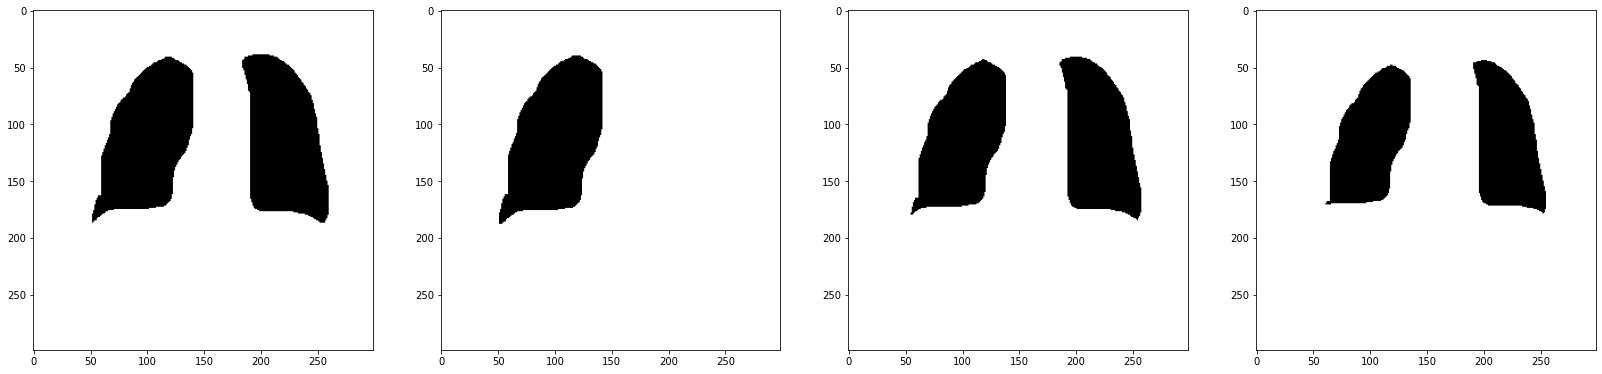

In [14]:
fig, ax = plt.subplots(1,4, figsize=(28,10))
ax[0].imshow(diff_tr_ff[1])
ax[1].imshow(eroded_ff[1])
ax[2].imshow(dilated_ff[1])
ax[3].imshow(dilated5_ff[1])

### Invert the masks

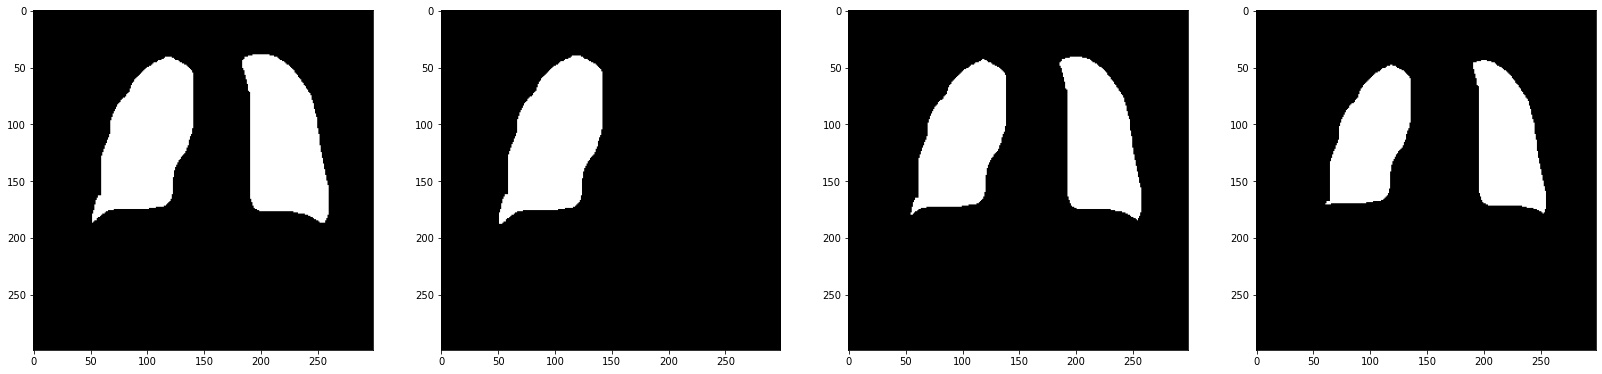

In [15]:
diff_tr_ff  = 255 - diff_tr_ff[1]
eroded_ff   = 255 - eroded_ff[1]
dilated_ff  = 255 - dilated_ff[1]
dilated5_ff = 255 - dilated5_ff[1]
fig, ax = plt.subplots(1,4, figsize=(28,10))
ax[0].imshow(diff_tr_ff)
ax[1].imshow(eroded_ff)
ax[2].imshow(dilated_ff)
ax[3].imshow(dilated5_ff)

## Applying the Masks to the Original Image

In [16]:
masked0 = cv2.bitwise_and(co1010_orig,co1010_orig, mask=diff_tr_ff[:,:,1])
masked1 = cv2.bitwise_and(co1010_orig,co1010_orig, mask=eroded_ff[:,:,1])
masked2 = cv2.bitwise_and(co1010_orig,co1010_orig, mask=dilated_ff[:,:,1])
masked3 = cv2.bitwise_and(co1010_orig,co1010_orig, mask=dilated5_ff[:,:,1])


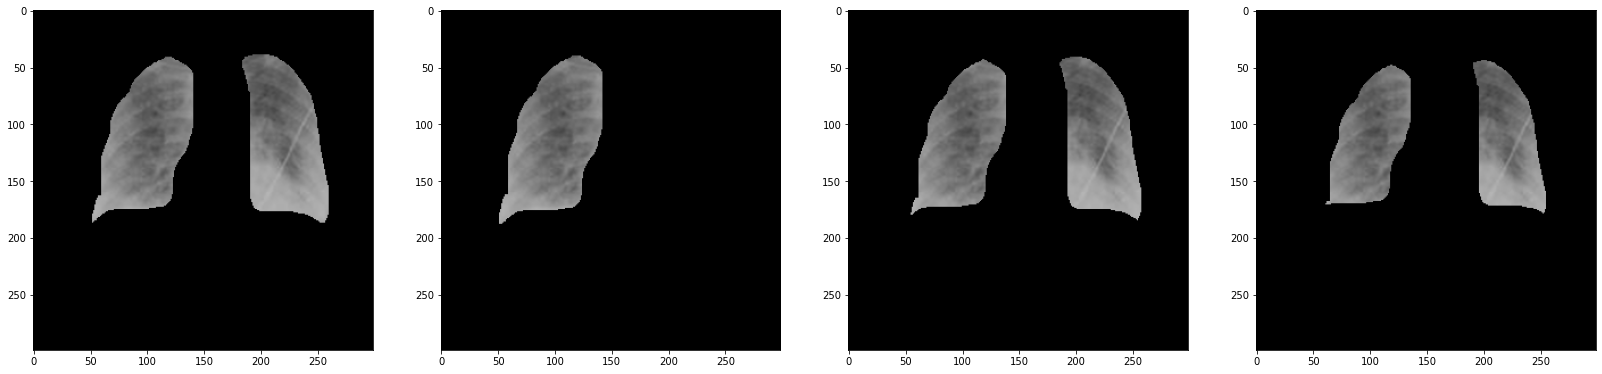

In [17]:
fig, ax = plt.subplots(1,4, figsize=(28,10))
ax[0].imshow(masked0)
ax[1].imshow(masked1)
ax[2].imshow(masked2)
ax[3].imshow(masked3)


## Dividing into Patches

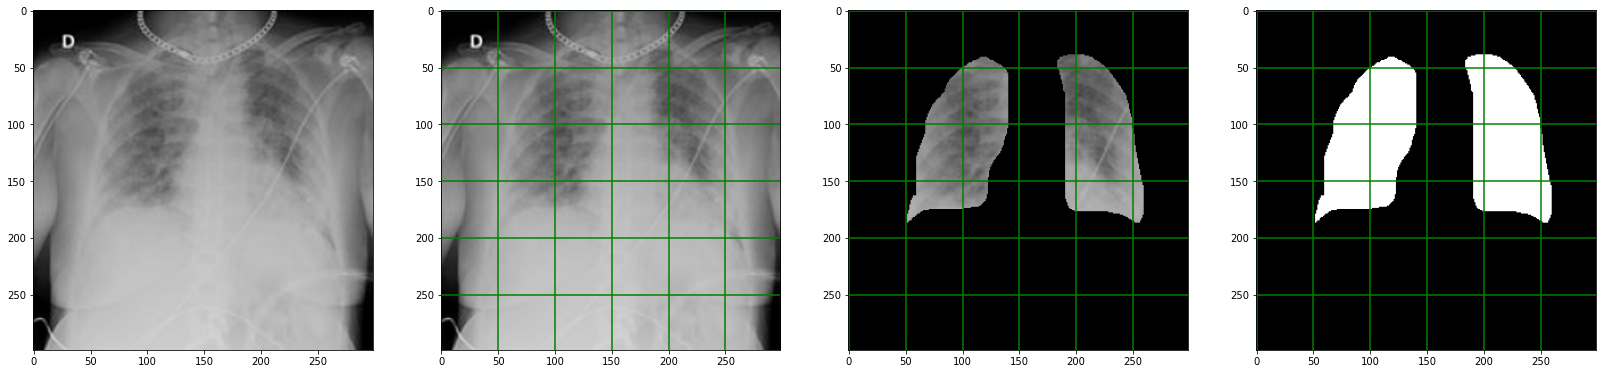

In [18]:
fig, ax = plt.subplots(1,4, figsize=(28,10))
ax[0].imshow(co1010_orig)
ax[1].imshow(co1010_orig)
ax[2].imshow(masked0)
ax[3].imshow(diff_tr_ff)

for j in range(1,4):
    for i in range(6):
        ax[j].axhline(50 * i, c="green")
        ax[j].axvline(50 * i, c="green")

In [19]:
## mask_0 = getmask(image, annot) ## Homework!!


image  = co1010_orig       ## original image
mask   = diff_tr_ff[:,:,1] ## mask
masked = masked0           ## maskedi image


height, width = co1010_orig.shape[:-1]
path_size = 16
step_size = 16  ## setting to 8 will produce overlapping patches

patch_directory = os.path.join("..","data","COVID-19_Radiography_Dataset","patches")

i = 0
while i <  height - 128:
    j = 0
    while j < width - 128:
        patch_0 = image[i:path_size+i, j:path_size+j, :] ###  ":" means "all channels"
        patch_m = mask [i:path_size+i, j:path_size+j   ] ###  " " means "0-th channel"

        number_of_pixels_from_ROI = sum(sum((patch_m//255)))
        ratio_of_pixels_from_ROI  = number_of_pixels_from_ROI // (path_size*path_size)
        
        if ratio_of_pixels_from_ROI > 0.25:  ### if a patch overlaps with ROI by at least 25%
            sample_name = image_file_name.split(".")[0]
            patch_file_name = sample_name + "_" + str(i) + "_" + str(j) + ".tif"
            patch_file_dir = os.path.join(patch_directory, patch_file_name)
            cv2.imwrite(patch_file_dir, patch_0) 

        j += step_size
    i += step_size

In [20]:
os.listdir(patch_directory)

['COVID-1010_112_112.tif',
 'COVID-1010_112_80.tif',
 'COVID-1010_112_96.tif',
 'COVID-1010_128_64.tif',
 'COVID-1010_128_80.tif',
 'COVID-1010_128_96.tif',
 'COVID-1010_144_64.tif',
 'COVID-1010_144_80.tif',
 'COVID-1010_144_96.tif',
 'COVID-1010_48_112.tif',
 'COVID-1010_64_112.tif',
 'COVID-1010_64_96.tif',
 'COVID-1010_80_112.tif',
 'COVID-1010_80_80.tif',
 'COVID-1010_80_96.tif',
 'COVID-1010_96_112.tif',
 'COVID-1010_96_80.tif',
 'COVID-1010_96_96.tif',
 'Thumbs.db']